In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
%matplotlib inline

C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [25]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [5]:
query = "SELECT * FROM analytical_data_table"
analytical_data = pd.read_sql(query, con=engine)

In [28]:
query = "SELECT TOP 10 * FROM whole_data_table"
whole_data = pd.read_sql(query, con=engine)

In [3]:
#with open('../../gci_project_storage/analytical_data.pickle', mode='rb') as f:
#     analytical_data = pickle.load(f)

<h3>データ整形

In [6]:
analytical_data = analytical_data.reindex(np.random.permutation(analytical_data.index)).reset_index().drop("index", axis=1)

In [7]:
X = analytical_data.iloc[:,3:]
y = analytical_data.iloc[:,:3].rent

<h3>重要度を確認

In [11]:
model_r = RandomForestRegressor(n_estimators=200)
model_r.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
importance = pd.Series(model_r.feature_importances_,index=X.columns)
print("駅の重要度合計：",importance[145:].sum())
print("間取りの重要度合計：",importance[50:55].sum())
for index,value in importance.sort_values(ascending=False).iteritems():
    print(index,":\t",value)

駅の重要度合計： 0.0669732362887
間取りの重要度合計： 0.311722132423
area :	 0.4261165283486308
has_L :	 0.30914701313633175
address_lat :	 0.04694327670973324
year_built :	 0.03750599009119652
address_lng :	 0.03320010484610684
渋谷駅 :	 0.01788831160728957
auto_lock :	 0.01390787638167863
恵比寿駅 :	 0.012327879331843221
buildings_height_Null_to_Zero :	 0.011029344149469586
refrigerator_Null_to_Zero :	 0.008806424857957821
表参道駅 :	 0.006439957537741597
locality_Null_to_Zero :	 0.004366138456783898
total_units_Null_to_Zero :	 0.004087091805645205
代々木公園駅 :	 0.0038177857091991237
明治神宮前駅 :	 0.0031288123502052696
bath_drier_Null_to_Zero :	 0.0027552054771722173
原宿駅 :	 0.002275854348493336
代々木八幡駅 :	 0.0015744508580821709
the_number_of_rooms :	 0.0014548916277310432
the_number_of_rooms_Null_to_Zero :	 0.001447474816480895
top_floor :	 0.001442319788134346
代官山駅 :	 0.0014172254686672337
stove_num_Null_to_Zero :	 0.0012953630288683076
代々木駅 :	 0.001188564317237567
structure :	 0.001184070268810826
structure_4 :	 0.00114

<h3>緯度経度で決定木どれだけ精度出せるか確認

In [8]:
X_place = analytical_data[["address_lat","address_lng"]]
model_toy = DecisionTreeRegressor()
model_toy.fit(X_place.iloc[:20000,:],y[:20000])
print(model_toy.score(X_place.iloc[20000:,:],y[20000:]))

0.364751966322


<h3>緯度経度による予測値の表示

In [9]:
X_place["pred"] = pd.Series([model_toy.predict(row.to_frame().T)[0] for i,row in X_place.iterrows()])
X_place = X_place[X_place.duplicated()==False]
X_place = X_place[X_place.pred<=40]
lat = X_place.address_lat
lng = X_place.address_lng
pred = X_place.pred

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
f = np.vectorize(lambda x,y:model_toy.predict(pd.Series([x,y]).to_frame().T))

In [10]:
geo_tags = pd.DataFrame({
        "lng":[139.701636,139.692101,139.7109,139.579809,139.759834,139.653912,139.799056,139.62667,139.650554,139.720918,139.645883,139.567597,139.607196]
        ,"lat":[35.657406,35.689634 ,35.729503,35.703149,35.706722 ,35.737841 ,35.733319 ,35.611705,35.668349 ,35.777658 ,35.79189  ,35.748321 ,35.684818]
        ,"location_name":["Sibuya","Shinjuku","Ikebukuro","Kichijoji","Hongo-Sanchome","Nerima","Minami-Senju","Fatako-Tamagawa","Meidai-Mae","Akabane","Nishi-Takashimadaira","Hoya","Hujimigaoka"]})

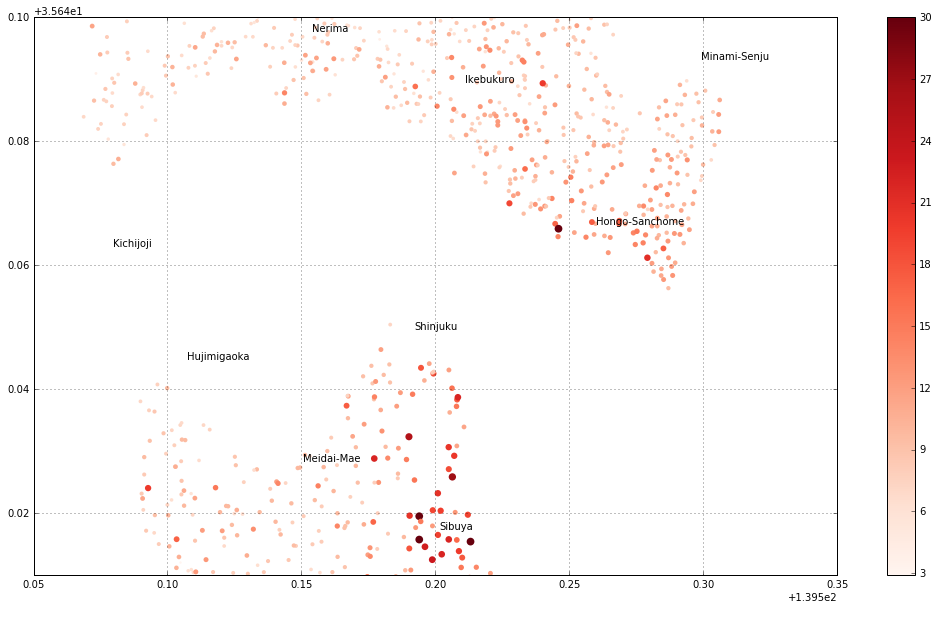

In [24]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)

plt.scatter(
    lng,lat
    ,c=pred.apply(lambda x:min(x,30))
    ,linewidths="0"
    ,cmap='Reds'
    ,alpha=1
    ,s=pred.apply(lambda x:min(x,30))*2
)
plt.colorbar()

for x0,y0,location_name in zip(geo_tags.lng, geo_tags.lat,geo_tags.location_name):                                  
    ax.annotate(location_name, xy=(x0,y0), textcoords='data')

plt.ylim(35.65,35.74)
plt.grid()
plt.show()

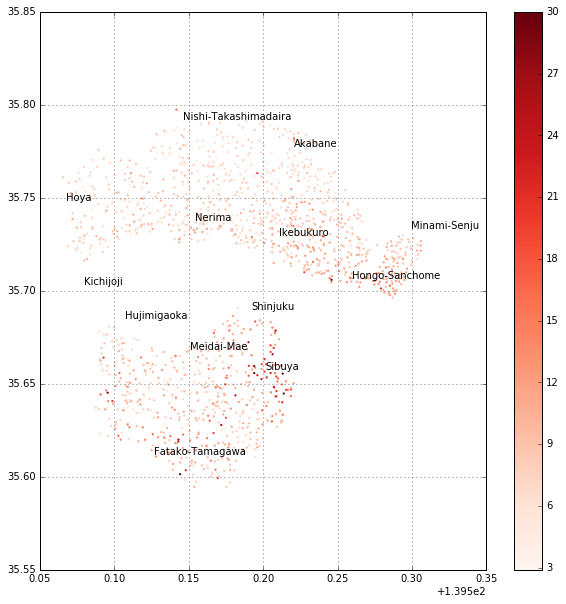

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.scatter(
    lng,lat
    ,c=pred.apply(lambda x:min(x,30))
    ,linewidths="0"
    ,cmap='Reds'
    ,alpha=1
    ,s=5
)
plt.colorbar()

for x0,y0,location_name in zip(geo_tags.lng, geo_tags.lat,geo_tags.location_name):                                  
    ax.annotate(location_name, xy=(x0,y0), textcoords='data')

plt.grid()
plt.show()

 データの範囲は、台東・文京・豊島・板橋・練馬・北・世田谷・渋谷・目黒<br>
 画像引用元：Wikipedia<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Tokyo_special_wards_map_ja.svg/400px-Tokyo_special_wards_map_ja.svg.png"
width="300" height="300" alt="" align="left">


<h3>最も高い駅を見つける

In [187]:
model_toy2 = Ridge(alpha=0.15)
model_toy2.fit(X,y)
coefficients_st = pd.Series(model_toy2.coef_,index=X.columns)[145:].sort_values(ascending=False)
print(coefficients_st[:10])

表参道駅      49.249988
明治神宮前駅    32.503928
代々木公園駅    29.974815
広尾駅       25.449603
恵比寿駅      16.641961
渋谷駅       13.775564
富士見ケ丘駅     9.305629
飯田橋駅       8.969808
参宮橋駅       8.080233
代官山駅       7.853476
dtype: float64


In [188]:
print(coefficients_st[-10:])

井荻駅             -7.498491
本所吾妻橋駅          -7.864473
三鷹台駅            -8.286306
快速南千住駅          -9.901780
雪が谷大塚駅         -10.505397
とうきょうスカイツリー駅   -10.734838
鷺ノ宮駅           -13.578558
都立家政駅          -15.775831
南千住駅           -18.104899
東向島駅           -18.622062
dtype: float64


In [190]:
coefficients = pd.Series(model_toy2.coef_,index=X.columns)
coefficients.index = X.columns

In [193]:
for i,value in coefficients.iteritems():
    print(i,"\t",round(value*10000)/10000.0)

area 	 0.3344
flooring 	 0.0789
year_built 	 0.0552
parking 	 -0.0245
structure 	 0.1051
air_conditioner 	 0.5008
auto_lock 	 0.3482
bath_toilet 	 -0.5105
reheating 	 -0.1454
wash_basin 	 -0.7138
washing_machine 	 -0.3317
top_floor 	 0.0303
corner_room 	 -0.1324
immediate 	 0.0629
upper 	 0.0255
direction_1 	 -0.0286
direction_2 	 -0.0456
direction_3 	 0.1103
direction_4 	 -0.1597
direction_5 	 -0.0381
direction_6 	 0.0926
direction_7 	 0.088
direction_8 	 0.1252
structure_1 	 -0.1277
structure_2 	 0.324
structure_3 	 0.4591
structure_4 	 -0.0324
structure_5 	 -0.8352
structure_6 	 0.5069
structure_7 	 -0.3814
structure_8 	 0.0
structure_9 	 -0.5101
structure_10 	 -0.1681
structure_11 	 0.7648
status_1 	 -0.1996
status_2 	 0.0388
status_3 	 0.2329
status_4 	 -0.0412
transaction_type_1 	 0.3372
transaction_type_2 	 -0.1052
transaction_type_3 	 0.2254
transaction_type_4 	 -0.8445
transaction_type_5 	 0.0173
transaction_type_6 	 0.3698
bath_style_0 	 0.5818
bath_style_1 	 -0.1164
bath_sty

<h3>Ridge回帰とDecision Treeの合成

In [60]:
class model_R_and_DT:
    
    def __init__(self):
        self.model_Ridge = Ridge(alpha=0.15)
        self.model_DT    = DecisionTreeRegressor()
        self.model_Linear_mix = LinearRegression(fit_intercept=False)
    
    def fit(self,X,y):
        # カラムの指定
        non_geo_col = X.columns[pd.Series(X.columns).apply(lambda col:(col!="address_lng")and(col!="address_lat"))]
        geo_col = pd.Series(["address_lat","address_lng"])
        # 個別の予測器の作成
        self.model_Ridge.fit(X[non_geo_col],y)
        self.model_DT.fit(X[geo_col],y)
        pred_Ridge = self.model_Ridge.predict(X[non_geo_col])
        pred_DT = self.model_DT.predict(X[geo_col])
        preds = pd.DataFrame({"pred_DT":pred_DT,"pred_ridge":pred_Ridge})
        self.model_Linear_mix.fit(preds,y)

    def predict(self,X):
        # カラムの指定
        non_geo_col = X.columns[pd.Series(X.columns).apply(lambda col:(col!="address_lng")and(col!="address_lat"))]
        geo_col = pd.Series(["address_lat","address_lng"])
        # 個別の予測器の統合
        pred_Ridge = self.model_Ridge.predict(X[non_geo_col])
        pred_DT = self.model_DT.predict(X[geo_col])
        preds = pd.DataFrame({"pred_DT":pred_DT,"pred_ridge":pred_Ridge})
        return self.model_Linear_mix.predict(preds)

    def score(self,X,y):
        pred = self.predict(X)
        mean = y.mean()
        return 1-sum((y-pred)**2)/sum((y-mean)**2)

In [73]:
class model_R_and_DT:
    
    def __init__(self):
        self.model_Ridge = Ridge(alpha=0.15)
        self.model_DT    = DecisionTreeRegressor()
        self.model_Linear_mix = LinearRegression(fit_intercept=False)
    
    def fit(self,X,y):
        # カラムの指定
        geo_col = pd.Series(["address_lat","address_lng"])
        non_geo_col = X.columns[pd.Series(X.columns).apply(lambda col:(col!="address_lng")and(col!="address_lat"))]
        X_new = X[non_geo_col]
        # 個別の予測器の作成
        self.model_DT.fit(X[geo_col],y)
        X_new["geo_effect"] = self.model_DT.predict(X[geo_col])
        self.model_Ridge.fit(X_new,y)
        
    def predict(self,X):
        # カラムの指定
        geo_col = pd.Series(["address_lat","address_lng"])
        non_geo_col = X.columns[pd.Series(X.columns).apply(lambda col:(col!="address_lng")and(col!="address_lat"))]
        X_new = X[non_geo_col]
        # 個別の予測器の作成
        X_new["geo_effect"] = self.model_DT.predict(X[geo_col])
        return self.model_Ridge.predict(X_new)

    def score(self,X,y):
        # カラムの指定
        geo_col = pd.Series(["address_lat","address_lng"])
        non_geo_col = X.columns[pd.Series(X.columns).apply(lambda col:(col!="address_lng")and(col!="address_lat"))]
        X_new = X[non_geo_col]
        # 個別の予測器の作成
        X_new["geo_effect"] = self.model_DT.predict(X[geo_col])
        return self.model_Ridge.score(X_new,y)

<h3>合成モデルの精度

In [74]:
model = model_R_and_DT()
model.fit(X.iloc[:20000,:],y[:20000])

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
model.score(X.iloc[20000:],y[20000:])

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.83920996485283239

In [76]:
model_R = Ridge(alpha=0.15)
model_R.fit(X.iloc[:20000,:],y[:20000])

Ridge(alpha=0.15, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [77]:
model_R.score(X.iloc[20000:],y[20000:])

0.81076007900976266

∴ダメ。精度でない。

<h3>残差の可視化

In [78]:
model_r_20000 = RandomForestRegressor(n_estimators=100)
model_r_20000.fit(X.iloc[:20000,:],y[:20000])
y_pred_20000 = model_r_20000.predict(X.iloc[20000:,:])

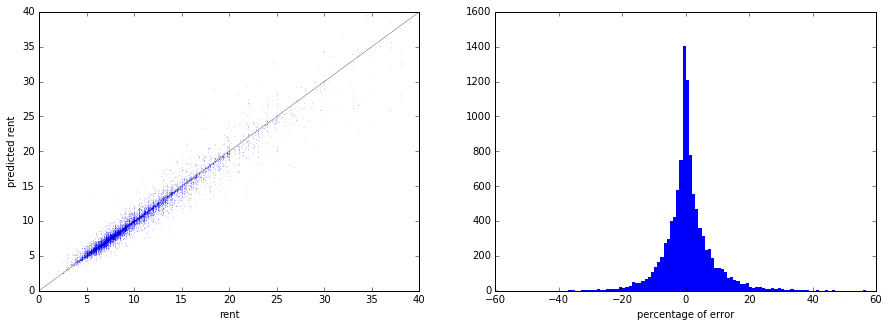

In [90]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x=y[20000:],y=y_pred_20000,s=1,linewidth=0,alpha=0.2)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("rent")
plt.ylabel("predicted rent")
plt.plot([0,40],[0,40],c="black",linewidth=0.3)
plt.subplot(1,2,2)
plt.hist((y_pred_20000/y[20000:]-1)*100, bins=range(-60,60),linewidth=0)
plt.xlim(-60,60)
plt.xlabel("percentage of error")
plt.show()

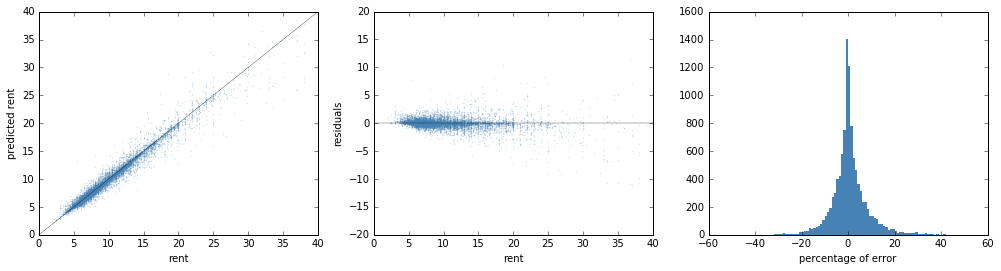

In [88]:
plt.figure(figsize=(17,4))

plt.subplot(1,3,1)
plt.scatter(x=y[20000:],y=y_pred_20000,s=2,alpha=0.2,linewidth=0,c="steelblue")
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("rent")
plt.ylabel("predicted rent")
plt.plot([0,40],[0,40],c="black",linewidth=0.3)

plt.subplot(1,3,2)
plt.scatter(x=y[20000:],y=y_pred_20000-y[20000:],s=2,alpha=0.2,linewidth=0,c="steelblue")
plt.xlim(0,40)
plt.ylim(-20,20)
plt.xlabel("rent")
plt.ylabel("residuals")
plt.plot([0,40],[0,0],c="black",linewidth=0.3)

plt.subplot(1,3,3)
plt.hist((y_pred_20000/y[20000:]-1)*100, bins=range(-60,60),linewidth=0,color="steelblue")
plt.xlim(-60,60)
plt.xlabel("percentage of error")
plt.show()

<h3>お買い得物件の検索

In [94]:
print("割高な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)>0].mean())
print("割安な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)<0].mean())

割高な物件の平均価格 11.17964393217767
割安な物件の平均価格 9.283456342668943


In [95]:
(y[20000:]-y_pred_20000).var()**(1/2)

2.372638248144472

In [96]:
percentage_price_pred = 100*(y_pred_20000/y[20000:]).sort_values(ascending=False)

In [97]:
index_bad_price = percentage_price_pred.sort_values(ascending=True).index
index_good_price = percentage_price_pred.sort_values(ascending=False).index

<h3>掲載停止の検査

In [98]:
import urllib
import re
import time

def is_404(url):
    time.sleep(3)
    try:
        uh = urllib.request.urlopen(url)
        return False
    except urllib.error.HTTPError as err:
        if err.code == 404:
            return True
        else:
            raise

In [99]:
good_404 = "割安物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_good_price[:100]].apply(is_404).sum())
bad_404 = "割高物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_bad_price[:100]].apply(is_404).sum())

In [100]:
print(good_404)
print(bad_404)

割安物件は、100件中58件が、掲載終了
割高物件は、100件中55件が、掲載終了


In [101]:
print("割高な物件")
for i in index_bad_price[0:100]:
    if is_404(list(analytical_data.url[X.index==i])[0])==False:
        print(list(analytical_data.url[X.index==i])[0]
              ,list(analytical_data.rent[X.index==i])[0]
              ,"万円　相場の"
              ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
              ,"％の価格！")

print("お買い得物件")
for i in index_good_price[0:100]:
    if is_404(list(analytical_data.url[X.index==i])[0])==False:
        print(list(analytical_data.url[X.index==i])[0]
              ,list(analytical_data.rent[X.index==i])[0]
              ,"万円　相場の"
              ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
              ,"％の価格！")

割高な物件
https://chintai.mynavi.jp/tokyo/113/room2385700005354.html 84.0 万円　相場の 245.54080362 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room3341500005354.html 42.0 万円　相場の 244.342311944 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room2128800001042.html 53.0 万円　相場の 184.720479576 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room6525800001322.html 135.0 万円　相場の 180.096051227 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room109700008499.html 48.0 万円　相場の 167.294019239 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room22300007704.html 55.0 万円　相場の 163.074094939 ％の価格！
https://chintai.mynavi.jp/tokyo/120/room26200007687.html 20.0 万円　相場の 156.581512421 ％の価格！
https://chintai.mynavi.jp/tokyo/120/room179100007258.html 8.0 万円　相場の 154.21686747 ％の価格！
https://chintai.mynavi.jp/tokyo/117/room600008895.html 7.35 万円　相場の 148.369949198 ％の価格！
https://chintai.mynavi.jp/tokyo/116/room693000004190.html 26.4 万円　相場の 146.13489801 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room2081700005354.html 11.0 万円　相場の 145.907945351 ％の価格！
https:/

In [102]:
analytical_data.year_built.mean()

1999.5950598802394

<h3>実装用の予測モデルの作成

In [53]:
X_avoid_0_to_7682 = X.iloc[pd.Series(range(7682,30728)),:]
X_avoid_7682_to_15364 = X.iloc[pd.Series(list(range(0,7682))+list(range(15364,30728))),:]
X_avoid_15364_to_23046 = X.iloc[pd.Series(list(range(0,15364))+list(range(23046,30728))),:]
X_avoid_23046_to_30728 = X.iloc[pd.Series(range(0,23046)),:]

y_avoid_0_to_7682 = y[pd.Series(range(7682,30728))]
y_avoid_7682_to_15364 = y[pd.Series(list(range(0,7682))+list(range(15364,30728)))]
y_avoid_15364_to_23046 = y[pd.Series(list(range(0,15364))+list(range(23046,30728)))]
y_avoid_23046_to_30728 = y[pd.Series(range(0,23046))]

RF_avoid_0_to_7682 = RandomForestRegressor(n_estimators=100).fit(X_avoid_0_to_7682,y_avoid_0_to_7682)
RF_avoid_7682_to_15364 = RandomForestRegressor(n_estimators=100).fit(X_avoid_7682_to_15364,y_avoid_7682_to_15364)
RF_avoid_15364_to_23046 = RandomForestRegressor(n_estimators=100).fit(X_avoid_15364_to_23046,y_avoid_15364_to_23046)
RF_avoid_23046_to_30728 = RandomForestRegressor(n_estimators=100).fit(X_avoid_23046_to_30728,y_avoid_23046_to_30728)
RF_whole_data = RandomForestRegressor(n_estimators=100).fit(X,y)
RF_models = {
    "RF_avoid_0_to_7682":RF_avoid_0_to_7682
    ,"RF_avoid_7682_to_15364":RF_avoid_7682_to_15364
    ,"RF_avoid_15364_to_23046":RF_avoid_15364_to_23046
    ,"RF_avoid_23046_to_30728":RF_avoid_23046_to_30728
    ,"RF_whole_data":RF_whole_data
}

In [54]:
with open('../../gci_project_storage/RF_models.pickle', mode='wb') as f:
     pickle.dump(RF_models, f)

In [55]:
train_data_urls = analytical_data.url

In [56]:
with open('../../gci_project_storage/train_data_urls.pickle', mode='wb') as f:
     pickle.dump(train_data_urls, f)

In [57]:
print("fin.")

fin.


<h3>最寄り駅関係のインサイト探し

In [30]:
station_names = analytical_data.columns[148:435]

get_min_inverse_to_station = lambda row_of_analytical_data: row_of_analytical_data[148:435].max()
get_min_to_station = lambda row_of_analytical_data:round((1.0/get_min_inverse_to_station(row_of_analytical_data))) if get_min_inverse_to_station(row_of_analytical_data)>0 else None
get_min_station = lambda row_of_analytical_data: list(station_names[get_min_inverse_to_station(row_of_analytical_data)==row_of_analytical_data[148:435]])[0]

In [37]:
data_min_to_station = pd.Series([get_min_to_station(row) for i,row in analytical_data.iterrows()])
data_min_stations = pd.Series([get_min_station(row) for i,row in analytical_data.iterrows()])

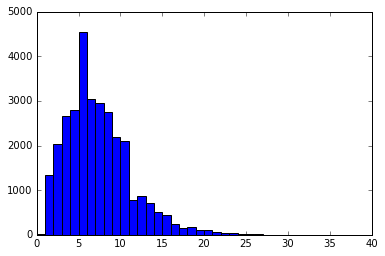

In [66]:
plt.hist(pd.Series(data_min_to_station).dropna(),bins=40,range=(0,40))
plt.show()

In [63]:
st_inverse_min_matrix = analytical_data.iloc[:,148:435].as_matrix().reshape(-1,)
st_min_matrix = np.vectorize(lambda x:1.0/x if x>0 else None)(st_min_matrix)
st_min_matrix = pd.Series(st_min_matrix).dropna()

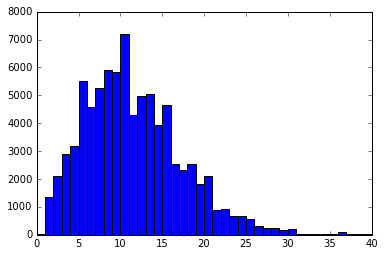

In [67]:
plt.hist(st_min_matrix,bins=40,range=(0,40))
plt.xlim(0,40)
plt.show()

∴そんなに面白い傾向はない

In [29]:
whole_data

,index,traffic,address,rent,area,deposit,key_money,brokerage_fee,date,layout,...,上井草駅,朝霞駅,下井草駅,沼袋駅,高円寺駅,三鷹駅,ひばりケ丘駅,中野駅,井の頭公園駅,阿佐ケ谷駅
0,5018,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.60,25.09,0,86000,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5019,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.60,25.09,0,86000,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5020,山手線上野駅?徒歩12分銀座線田原町(東京都)駅?徒歩6分銀座線稲荷町(東京都)駅?徒歩7分,東京都台東区元浅草４丁目,8.65,25.09,0,86500,"46,710",2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5021,山手線上野駅?徒歩12分銀座線田原町(東京都)駅?徒歩6分銀座線稲荷町(東京都)駅?徒歩7分,東京都台東区元浅草４丁目,8.65,25.09,0,86500,"46,710",2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5022,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.65,25.09,0,86500,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5023,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.65,25.09,0,86500,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5024,山手線上野駅?徒歩12分銀座線田原町(東京都)駅?徒歩6分銀座線稲荷町(東京都)駅?徒歩7分,東京都台東区元浅草４丁目,8.70,25.09,0,87000,"46,980",2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5025,山手線上野駅?徒歩12分銀座線田原町(東京都)駅?徒歩6分銀座線稲荷町(東京都)駅?徒歩7分,東京都台東区元浅草４丁目,8.70,25.09,0,87000,"46,980",2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5026,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.70,25.09,0,87000,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5027,銀座線田原町(東京都)駅?徒歩6分都営大江戸線新御徒町駅?徒歩10分山手線上野駅?徒歩17分,東京都台東区元浅草４丁目,8.70,25.09,0,87000,None,2017年7月,1K,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
